In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime
import h5py
import pickle

import tensorflow as tf
from tensorflow.python.keras.layers import Activation, Input, SimpleRNN, Dense, LSTM
from tensorflow.python.keras.models import Model, Sequential, model_from_json
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.optimizers import Adam

print('numpy v{}'.format(np.__version__))                 # v1.14.3
print('pandas v{}'.format(pd.__version__))                # v0.23.0
print('tensorflow v{}'.format(tf.__version__))            # v1.8.0
print('matplotlib v{}'.format(matplotlib.__version__))    # v2.2.2

%matplotlib inline

numpy v1.14.3
pandas v0.22.0
tensorflow v1.8.0
matplotlib v2.2.2


# LOAD and VISUALIZE INPUTS

In [7]:
def load_data(csv_file_path, verbose = True):
    '''
    Load and vizualize csv data
    
    ## Inputs
    csv_file_path (string): example "../data/inputs/characters_data.csv"
    verbose (boolean): show some feedbacks
    ## Outputs
    data (DataFrame): including 2 series Name and Race
    '''
    data = pd.read_csv(csv_file_path)
    
    if verbose:
        print('## Data info:')
        display(data.info())
        
        print('## Data describe:')
        display(data.describe())
        
        print('## Data describe (inluding objects):')
        display(data.describe(include=['object']))
        
        print('##Data extracts:')
        display(data.agg([lambda s: set((s.drop_duplicates().tolist()))]).T['<lambda>'])
    return data

In [8]:
# Load data

lotr       = load_data('../data/inputs/characters_data.csv')
firstnames = load_data('../data/inputs/first_names.csv')

## Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 2 columns):
name    827 non-null object
race    827 non-null object
dtypes: object(2)
memory usage: 13.0+ KB


None

## Data describe:


,name,race
count,827,827
unique,774,5
top,Beren,Man
freq,3,419


## Data describe (inluding objects):


,name,race
count,827,827
unique,774,5
top,Beren,Man
freq,3,419


##Data extracts:


name    {Hamson Gamgee, Éothain, Elphir, Náin, Urwen, ...
race                     {Hobbit, Man, Elf, Ainur, Dwarf}
Name: <lambda>, dtype: object

## Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5494 entries, 0 to 5493
Data columns (total 1 columns):
firstname    5494 non-null object
dtypes: object(1)
memory usage: 43.0+ KB


None

## Data describe:


,firstname
count,5494
unique,5163
top,Jewel
freq,2


## Data describe (inluding objects):


,firstname
count,5494
unique,5163
top,Jewel
freq,2


##Data extracts:


firstname    {Elida, Jack, Pearlie, Malcom, Giuseppe, Corri...
Name: <lambda>, dtype: object

<Figure size 432x288 with 0 Axes>

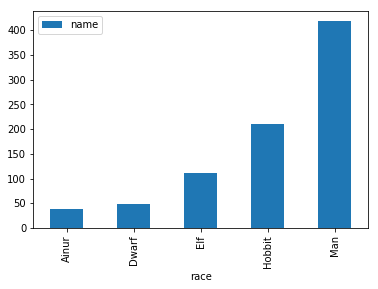

<Figure size 432x288 with 0 Axes>

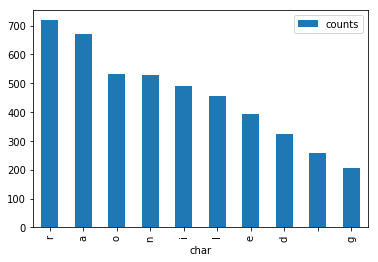

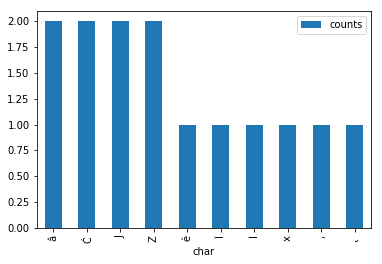

In [9]:
# Visualize LOTR data

plt.figure('Races')
lotr.groupby('race').count().plot.bar()

plt.figure('Chars')
lotr_chars = pd.DataFrame(data={'char': list(lotr['name'].str.cat())})
lotr_chars_count = lotr_chars.groupby('char').size().reset_index(name='counts')
lotr_chars_count = lotr_chars_count.set_index('char').sort_values('counts', ascending =False)

lotr_chars_count[:10].plot(kind="bar")
lotr_chars_count[-10:].plot(kind="bar")

# CLEAN DATA

In [10]:
def clean_lotr_data(data, padding_start = '#', padding_end = '*', verbose=True):
    '''
    Clean LOTR data, removing unwanted characters and adding some padding
    
    ## Inputs
    data (DataFrame): including name and race columns
    padding_start (string): character to add to the start of a name
    padding_end (string): character to add to the end of a name
    verbose (boolean): show some feedbacks
    ## Outputs
    data (DataFrame): including 2 series "name" and 'group'
    '''
    # Create a copy
    data_cleaned = data.copy()
    
    # Rename the grouping column
    data_cleaned = data_cleaned.rename(columns={'race': 'group'})
    
    # Cleaning operations
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.strip(" -."))        # remove unwanted starting/ending chars
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.rstrip(" VI"))       # remove unwanted starting/ending chars
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.replace('\xad', '')) # remove soft hyphen
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.replace('#', ''))    # replace characters used for training
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.replace('*', ''))    # replace characters used for training
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.split(',', 1)[0])    # remove titles
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: padding_start + n + padding_end) # Add padding chars
    # padding characters is used to ease the training data generation
    
    print('{} rows cleaned !'.format(len(data_cleaned))) if verbose else None
    
    return data_cleaned

In [11]:
def clean_firstnames_data(data, padding_start = '#', padding_end = '*', verbose=True):
    '''
    Clean First Names data, removing unwanted characters and adding some padding
    
    ## Inputs
    data (DataFrame): including name and race columns
    padding_start (string): character to add to the start of a name
    padding_end (string): character to add to the end of a name
    verbose (boolean): show some feedbacks
    ## Outputs
    data (DataFrame): including 2 series 'name' and 'group'
    '''
    # Create a copy
    data_cleaned = data.copy()
    
    # Rename the main column
    data_cleaned = data_cleaned.rename(columns={'firstname': 'name'})
    
    # Add a grouping colmun
    data_cleaned['group'] = 'Real'
    
    # Cleaning operations
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.replace('\xad', '')) # remove soft hyphen
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.replace('#', ''))    # replace characters used for training
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: n.replace('*', ''))    # replace characters used for training
    data_cleaned['name'] = data_cleaned['name'].map(lambda n: padding_start + n + padding_end) # Add padding
    # padding characters is used to ease the training data generation
    
    print('{} rows cleaned !'.format(len(data_cleaned))) if verbose else None
    
    return data_cleaned

827 rows cleaned !
5494 rows cleaned !


,name,group
count,6321,6321
unique,5896,6
top,#Húrin*,Real
freq,5,5494


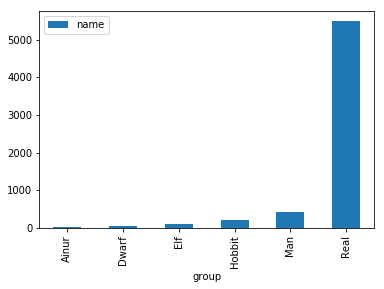

In [12]:
# Clean data

# Padding characters is used to ease the training data generation
# We will use them to create fix-sized sequences to feed our model during training and prediction
padding_start = '#'
padding_end = '*'

# Create clean dataframe with name and group columns
# remove unwanted characters and with padding chararcters : '#' + name + '*'
lotr_cleaned = clean_lotr_data(lotr, padding_start, padding_end)                   # group : Man, Elf, Hobbit, ...
firstnames_cleaned = clean_firstnames_data(firstnames, padding_start, padding_end) # group : Real

# Merge all cleaned data
clean_data = pd.concat([lotr_cleaned, firstnames_cleaned])

display(clean_data.describe())
clean_data.groupby('group').count().plot.bar()

In [13]:
# Visualization of data cleaning

# Pick some LOTR names to be cleaned
examples_index = np.r_[0, 155, 165, 385, 498, 575, 721] 
print('Example of names to be cleaned:')
print(lotr.loc[examples_index])
print('Max name size: {}'.format(lotr['name'].map(len).max()))
print('--\n')

print('Cleaned names:')
print(lotr_cleaned.loc[examples_index])
print('Max name size: {}'.format(lotr_cleaned['name'].map(len).max()))
print('--\n')

print('Firstnames:')
print(firstnames_cleaned[:5])
print('Max name size: {}'.format(firstnames_cleaned['name'].map(len).max()))
print('--\n')

Example of names to be cleaned:
                   name    race
0            Aragorn II     Man
155            Durin VI   Dwarf
165             Dáin II   Dwarf
385        Tar-Meneldur     Man
498  Otho Sackville-...  Hobbit
575  Tolman Cotton, Jr.  Hobbit
721              Amdí­r     Elf
Max name size: 20
--

Cleaned names:
                 name   group
0           #Aragorn*     Man
155           #Durin*   Dwarf
165            #Dáin*   Dwarf
385    #Tar-Meneldur*     Man
498  #Otho Sackville*  Hobbit
575   #Tolman Cotton*  Hobbit
721           #Amdír*     Elf
Max name size: 22
--

Firstnames:
      name group
0  #Aaron*  Real
1  #Aaron*  Real
2  #Abbey*  Real
3  #Abbie*  Real
4   #Abby*  Real
Max name size: 13
--



# TRANSFORM DATA

In [14]:
def build_inputs(data_cleaned, verbose=True):
    '''
    Build data for RNN model
    
    ## Inputs:
    data_cleaned (DataFrame): including 2 series 'name' and 'group'
    verbose (boolean): show some feedbacks
    ## Outputs:
    data_dict (dict): dictionary with one entry per group
                        Each group entry is a dictionnary with
                            - group (string)
                            - name_list (list): list of strings
                            - char_list (list): list of unique characters included in all names
                            - char_to_ix (dict): to transform a character in its corresponding index in char_list
                            - ix_to_char (dict): to transform a index in its corresponding character in char_list
    '''
    groups = data_cleaned['group'].unique()

    data_dict = {}

    for r in groups:
        data_dict[r] = {}
        data_dict[r]['group'] = r
        data_dict[r]['name_list'] = data_cleaned[data_cleaned['group'] == r]['name']
        data_dict[r]['char_list'] = sorted(list(set(data_dict[r]['name_list'].str.cat() + '*')))
        data_dict[r]['char_to_ix'] = { ch:i for i,ch in enumerate(data_dict[r]['char_list']) }
        data_dict[r]['ix_to_char'] = { i:ch for i,ch in enumerate(data_dict[r]['char_list']) }

    if verbose:
        for k, v in data_dict.items():
            print('group: {}'.format(k))
            print('  - number of names: {} ({}, ...)'.format(len(v['name_list']), v['name_list'][:5].tolist()))
            print('  - number of chars: {}'.format(len(v['char_list'])))
            print('  - chars: {}'.format(v['char_list']))
            print('  - char_to_ix: {}'.format(v['char_to_ix']))
            print('  - ix_to_char: {}'.format(v['ix_to_char']))
            print('######################')
    
    return data_dict

In [15]:
# Build model input data

# Create a data dictionnary
data_dict = build_inputs(clean_data)
# lotr_data_dict = build_lotr_inputs(lotr_cleaned)
# firstnames_data_dict = build_lotr_inputs(firstnames_cleaned)

group: Man
  - number of names: 419 (['#Aragorn*', '#Tuor*', '#Vardamir*', '#Tindómiel*', '#Manwedil*'], ...)
  - number of chars: 63
  - chars: ['#', '*', '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'É', 'Í', 'Î', 'á', 'â', 'ä', 'é', 'ê', 'ë', 'í', 'ó', 'ô', 'ú', 'û']
  - char_to_ix: {'u': 43, 'Î': 51, 'N': 14, 'á': 52, 'ú': 61, 'o': 38, 'é': 55, 'x': 46, 'k': 34, 'A': 3, 'a': 25, 'H': 10, 'û': 62, 'm': 36, 'R': 17, 'l': 35, 'n': 37, 'B': 4, 'í': 58, 'C': 5, 'V': 21, 'Z': 24, 'D': 6, 'G': 9, 'r': 40, 'Í': 50, '-': 2, 'T': 19, 'c': 27, 'M': 13, 'g': 31, 'P': 16, 'w': 45, 'z': 48, '*': 1, 'i': 33, 'y': 47, 'd': 28, 'F': 8, 'U': 20, 'ä': 54, 'ó': 59, '#': 0, 't': 42, 'h': 32, 'ô': 60, 'Y': 23, 'v': 44, 'e': 29, 'S': 18, 'b': 26, 'ê': 56, 'É': 49, 'f': 30, 'â': 53, 'O': 15, 'W': 22, 'I': 11, 'p': 39, 

In [16]:
def init_training_data(
    target_group, data_dict,
    length_of_sequence = 3, verbose = True):
    '''
    Initialise training data X and Y and some helpers
    
    ## Inputs:
    target_group (string) : key to select names in data_dict (e.g. 'Man', 'Elf', ..., 'Real')
    data_dict (dict): dictionary with one entry per group
                        Each group entry is a dictionnary with
                            - group (string)
                            - name_list (list): list of strings
                            - char_list (list): list of unique characters included in all names
                            - char_to_ix (dict): to transform a character in its corresponding index in char_list
                            - ix_to_char (dict): to transform a index in its corresponding character in char_list
    length_of_sequence (integer): size of the input sequence of the RNN 
        To be choosen by the user:
            - bigger length means more weights in the RNN, slower training but higher "memory" capabilities
            - smaller length means easier to train but kind of "oblivious" RNN
    verbose (boolean): show some feedbacks
    ## Outputs:
    X (ndarray): shape (m, length_of_sequence, number_of_chars) of boolean data
    Y (ndarray): shape (m, number_of_chars) of boolean data
    (c2i, i2c): utils dictionnary used to convert character to index of "one hot vector" and vice versa
    trainset_infos (dict): description of the dataset
        - target_group (string): cf Inputs
        - length_of_sequence (integer): size of the input sequence for the RNN model
        - number_of_chars (integer): number of unique character in the trainset
    '''

    # Extract target names to list (currently '#name*')
    training_names = data_dict[target_group]['name_list'].tolist()
    
    # Extract padding characters
    padding_start = training_names[0][0]
    padding_end = training_names[0][-1]

    # Extract target character convertors
    # This will be used to convert a character to its "one hot index" and vice versa (cf Keras to_categorical())
    c2i = data_dict[target_group]['char_to_ix']
    i2c = data_dict[target_group]['ix_to_char']
    
    # Extract the target number of characters in all target names
    # This will be used to convert character index in its "one hot" representation (cf Keras to_categorical())
    number_of_chars = len(data_dict[target_group]['char_list'])
    
    # Pad target names with enough (lengh_of_sequence) padding characters (result '##...##name**...**' )
    # The goal is  be sure that, for each name, the first training data is X[0] = '##...##'
    # and Y[0] = First actual character of the name
    training_names = [
        padding_start * (length_of_sequence - 1) + n + padding_end * (length_of_sequence - 1) for n in training_names
    ]

    # Init X and Y as list
    X_list = []
    Y_list = []

    # Init counter for visual feedback
    counter = 0 if verbose else None
    
    for name in training_names:
        # Slide a window on the name, one character at a time
        for i in range(max(1, len(name) - length_of_sequence)):
            # Extract the new sequence and the character following this sequence
            new_sequence = name[i:i + length_of_sequence]
            target_char = name[i + length_of_sequence]
            
            # Add the new sequence to X (input of the model)
            X_list.append([to_categorical(c2i[c], number_of_chars) for c in new_sequence])
            # Add the following character to Y (target to be predicted by the model)
            Y_list.append(to_categorical(c2i[target_char], number_of_chars))

        # visual feedback
        if verbose:
            counter += 1
            print(counter) if counter % 100 == 0 else print('.', end='')

    # Convert X and Y to numpy array
    X = np.array(X_list)
    Y = np.array(Y_list)
    
    # Extract the number of training samples
    m = len(X)

    print(
        '{} names split in {} training sequence of {} encoded chars !'.format(counter, m, length_of_sequence)
    ) if verbose else None
    
    # Create a description of the trainset
    trainset_infos = {
        'target_group': target_group,
        'length_of_sequence': length_of_sequence,
        'number_of_chars': number_of_chars,
        'm': m,
        'padding_start': padding_start,
        'padding_end': padding_end,
    }

    # Visual feedbacks
    if verbose:
        print('X shape: {}'.format(X.shape))
        print('Y shape: {}'.format(Y.shape))

        print('X[0] = {}'.format(X[0]))
        print('Y[0] = {}'.format(Y[0]))

        print('Training set size: {}'.format(m))
        print('length_of_sequence: {}'.format(length_of_sequence))
        print('number_of_chars: {}'.format(number_of_chars))
    
    return X, Y, {'c2i': c2i, 'i2c': i2c}, trainset_infos

In [339]:
X, Y, trainset_utils, trainset_infos = init_training_data(
    target_group = 'Real',
    data_dict = data_dict,
    length_of_sequence = 5,
)

...................................................................................................100
...................................................................................................200
...................................................................................................300
...................................................................................................400
...................................................................................................500
...................................................................................................600
...................................................................................................700
...................................................................................................800
...................................................................................................900
.........................................................................

# CREATE MODEL

In [430]:
def create_model(trainset_infos, lstm_units = 256, verbose = True):
    '''
    Create the Keras RNN model and some helpers
    
    ## Inputs:
    trainset_infos (dict): description of the trainset to be used on the model (cf. init_training_data)
        - m (integer): number of 
        - length_of_sequence (integer): size of an input sample (number of characters)
        - number_of_chars (integer): size of the character dictionnary (number of different character in all input samples)
    verbose (boolean): show some feedbacks
    ## Outputs:
    model (keras model):
        - Architecture:
            * One Input layer taking an undefined batch size of sequences. Each sequence is length_of_sequence long
                and each character is encoded in a number_of_chars "one-hot vector"
            * One LSTM layer with 256 units
            * One Dense layer converting 256 to number_of_chars
            * One Softmax layer to 
    training_infos (dict): description of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
        - trainset_infos (dict): description of the trainset
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    '''
    length_of_sequence = trainset_infos['length_of_sequence']
    number_of_chars = trainset_infos['number_of_chars']
    
    X_input = Input(shape=(length_of_sequence, number_of_chars))
    
    #X = SimpleRNN(units=number_of_chars)(X_input)
    X = LSTM(units=lstm_units)(X_input) # default 256
    X = Dense(units=number_of_chars)(X)
    
    Output = Activation('softmax')(X)
    
    model = Model(inputs=X_input, outputs=Output)
    training_infos = {
        'total_epochs': 0,
        'loss': 0,
        'acc': 0,
        'trainset_infos': trainset_infos,
    }
    history = {
        'loss': np.array([]),
        'acc': np.array([]),
        'hyperparams': []
    }
    model.summary()
    return model, training_infos, history

In [431]:
current_model, training_infos, history = create_model(trainset_infos = trainset_infos, lstm_units= 64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 5, 54)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                30464     
_________________________________________________________________
dense_12 (Dense)             (None, 54)                3510      
_________________________________________________________________
activation_12 (Activation)   (None, 54)                0         
Total params: 33,974
Trainable params: 33,974
Non-trainable params: 0
_________________________________________________________________


# TRAIN MODEL

In [52]:
def compile_model(model, hyperparams, history, verbose=True):
    '''
    Compile the Keras model with new hyperparams on Adam optimizer and save this hyperparams in history
    
    ## Inputs:
    model (Keras model): Keras RNN model
    hyperparams (dict): List of hyperparams
        - lr (float): learning rate
        - loss (string): loss function
        - batch_size (int): batch size
    verbose (boolean): show some feedbacks
    ## Outputs:
    None
    '''
    optimizer = Adam(lr=hyperparams['lr'])

    model.compile(loss=hyperparams['loss'], optimizer=optimizer, metrics = ["accuracy"])

    history['hyperparams'].append((training_infos['total_epochs'], hyperparams))
    
    print(history['hyperparams']) if verbose else None
    
    return None

In [432]:
compile_model(
    model = current_model,
    hyperparams = {
        'lr': 0.003,                       # default 0.003
        'loss': 'categorical_crossentropy', # default 'categorical_crossentropy'
        'batch_size': 32,                   # default 32
    },
    history = history
)

[(0, {'batch_size': 32, 'lr': 0.003, 'loss': 'categorical_crossentropy'})]


In [54]:
def train_model(model, X, Y, training_infos, history, epochs_to_add = 10, verbose = True):
    '''
    Train the Keras model then update training session info and history
    
    ## Inputs:
    model (Keras model): Keras RNN model
    X (ndarray): Input of the training. List of sequences of encoded characters.
        Numpy array of shape (m, length_of_sequence, number_of_chars)
    Y (ndarray): Ouput to be predicted. List of encoded character expected the corresponding input sequence.
        Numpy array of shape (m, number_of_chars)
    training_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    verbose (boolean): show some feedbacks
    ## Outputs:
    None
    '''
    # Extract previous loss and accuracy to give feedback at the end of the session
    old_loss = training_infos['loss']
    old_acc = training_infos['acc']
    
    # Extract hyperparams to fit the model
    hyperparams = history['hyperparams'][-1][1]
    
    # Train the model
    h = model.fit(
        X, Y,
        batch_size=hyperparams['batch_size'],
        initial_epoch=training_infos['total_epochs'],
        epochs = training_infos['total_epochs'] + epochs_to_add
    )


    # Update history
    for key, val in h.history.items():
        history[key] = np.append(history[key], val)
    
    # Update the training session info
    training_infos['total_epochs'] += epochs_to_add
    training_infos['loss'] = history['loss'][-1]
    training_infos['acc' ] = history['acc' ][-1]
    
    if verbose:
        print('new loss: {:.5f} ({:.5f})'.format(training_infos['loss'], training_infos['loss'] - old_loss))
        print('new acc : {:.5f} ({:.5f})'.format(training_infos['acc'], training_infos['acc'] - old_acc))
        print('history size: {}'.format(len(history['loss'])))

    return None

In [372]:
train_model(current_model, X, Y, training_infos, history, epochs_to_add = 5, verbose = True)

Epoch 101/105
60211/60211 [==============================] - 24s 399us/step - loss: 0.9299 - acc: 0.6873
Epoch 102/105
60211/60211 [==============================] - 20s 328us/step - loss: 0.9295 - acc: 0.6872
Epoch 103/105
60211/60211 [==============================] - 20s 326us/step - loss: 0.9293 - acc: 0.6874
Epoch 104/105
60211/60211 [==============================] - 21s 351us/step - loss: 0.9292 - acc: 0.6877
Epoch 105/105
60211/60211 [==============================] - 21s 345us/step - loss: 0.9290 - acc: 0.6876
new loss: 0.92904 (-0.00466)
new acc : 0.68765 (0.00148)
history size: 105


In [57]:
def generate_name(
    model, trainset_infos, trainset_utils,
    name_max_length = 25,
    verbose=False
):
    '''
    Generate some name with the RNN model
    
    ## Inputs:
    model (Keras model): 
    trainset_infos (dict): description of the dataset
        - target_group (string): cf Inputs
        - length_of_sequence (integer): size of the input sequence for the RNN model
        - number_of_chars (integer): number of unique character in the trainset
    trainset_utils (dict): utils dictionnary used to convert character to index of "one hot vector" and vice versa
        - c2i (dict): character to index
        - i2c (dict): index to character
    name_max_length (integer): max size of the generated name
    verbose (boolean): show some feedbacks
    ## Outputs:
    generated_name (string): name generated by the RNN
    (probability, gap): few numbers about this generated name
        probability: probability to generate this name (cummulative probability to select each character)
        ecart: gap between best name and this name (cummulative sum of gaps between selected character and best character)
        
    '''
    # Extract the number of unique character in trainset
    dict_size = trainset_infos['number_of_chars']
    
    # Extract the size of an input sequence
    sequence_length = trainset_infos['length_of_sequence']
    
    # Extract utils dictionnary to convert character to one hot index and vice versa
    i2c = trainset_utils['i2c']
    c2i = trainset_utils['c2i']
    
    # Extract padding character
    padding_start = trainset_infos['padding_start']
    
    # Init a name full of padding_start character
    generated_name = padding_start * (sequence_length + name_max_length)

    # Init counters
    probability = 1
    gap = 0
    
    # Generate new character from current sequence
    for i in range(name_max_length):
        # Extract current sequence from generated character
        x_char = generated_name[i:i+sequence_length]
        
        # Convert current sequence to one hot vector
        x_cat = np.array([[to_categorical(c2i[c], dict_size) for c in x_char]])
        
        # Predict new character probabilities
        # Actually this output a list of probabilities for each character
        p = model.predict(x_cat)

        # Extract the best character (and its probability)
        best_char = i2c[np.argmax(p)]
        best_char_prob = np.max(p)

        # Choose a random character index according to their probabilities (and its probability)
        new_char_index = np.random.choice(range(dict_size), p = p.ravel())
        new_char_prob = p[0][new_char_index]
        
        # Convert the index to an actual character
        new_char = i2c[new_char_index]
                
        # Update the generated name with the new character
        generated_name = generated_name[:sequence_length+i] + new_char + generated_name[sequence_length+i+1:]
        
        # Update counters
        probability *= new_char_prob # probabilities are multiplied
        gap += best_char_prob-new_char_prob # gaps are summed

        # Show some feedbacks
        if verbose:
            print(
                'i={} new_char: {} ({:.3f}) [best:  {} ({:.3f}), diff: {:.3f}, prob: {:.3f}, gap: {:.3f}]'.format(
                    i,
                    new_char,
                    new_char_prob,
                    best_char,
                    best_char_prob,
                    best_char_prob-new_char_prob,
                    probability,
                    gap
                )
            )

        # Stop the prediction loop if it reached a 'padding_end' character
        if (new_char == trainset_infos['padding_end']):
            break
    
    # Clean the generated name
    generated_name = generated_name.strip('#*')
    
    # Show some feedbacks
    print('{} (probs: {:.6f}, gap: {:.6f})'.format(generated_name, probability, gap)) if verbose else None

    return generated_name, {'probability': probability, 'gap': gap}

In [346]:
def plot_training_session(training_infos, history, last_n = 30, verbose=True):
    '''
    Plot some graphs about history
    
    ## Inputs:
    training_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    verbose (boolean): show some feedbacks
    ## Outputs:
    None
    '''
    # Plot full history loss
    plt.plot(range(len(history['loss'])), history['loss'])
    
    # Plot loss on last n epochs
    plt.figure()
    last_n = min(last_n,len(history['loss']))
    plt.plot(range(last_n), history['loss'][-last_n:])
    
    if verbose:
        # Print training session infos
        print('training_infos: {}'.format(json.dumps(training_infos, indent=2)))
        
        # Print evolution of hyperparams
        print('history: {}'.format(json.dumps(history['hyperparams'][-3:], indent=2)))
        
    return None

training_infos: {
  "total_epochs": 105,
  "trainset_infos": {
    "number_of_chars": 54,
    "length_of_sequence": 5,
    "padding_end": "*",
    "target_group": "Real",
    "m": 60211,
    "padding_start": "#"
  },
  "acc": 0.6876484363312417,
  "loss": 0.9290395355931815
}
history: [
  [
    85,
    {
      "batch_size": 32,
      "lr": 0.003,
      "loss": "categorical_crossentropy"
    }
  ],
  [
    95,
    {
      "batch_size": 32,
      "lr": 0.001,
      "loss": "categorical_crossentropy"
    }
  ],
  [
    100,
    {
      "batch_size": 32,
      "lr": 0.0003,
      "loss": "categorical_crossentropy"
    }
  ]
]
current samples: [('Sileon', {'gap': 1.3606390729546547, 'probability': 5.056683844071739e-07}), ('Willie', {'gap': 0.07722275704145432, 'probability': 0.0004335929200053688}), ('Shawn', {'gap': 0.2958814576268196, 'probability': 0.0004210579214831048})]


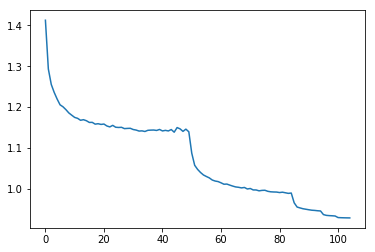

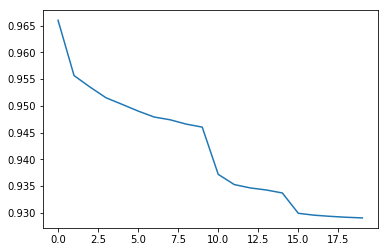

In [373]:
# Plot loss history
plot_training_session(training_infos, history, last_n = 20)

# Print some sample of generated names
samples = []
for i in range(3):
    samples.append(generate_name(
        model=current_model,
        trainset_infos=trainset_infos,
#         sequence_length=trainset_infos['length_of_sequence'],
        trainset_utils=trainset_utils,
#         padding_start=padding_start,
#         padding_end=padding_end,
        name_max_length=25,
        verbose=False))
print('current samples: {}'.format(samples))

# PLAY with MODEL

In [404]:
new_name = generate_name(
    model=current_model,
    trainset_infos=trainset_infos,
    trainset_utils=trainset_utils,
    name_max_length=25,
    verbose=True)

i=0 new_char: J (0.071) [best:  M (0.093), diff: 0.022, prob: 0.071, gap: 0.022]
i=1 new_char: a (0.309) [best:  a (0.309), diff: 0.000, prob: 0.022, gap: 0.022]
i=2 new_char: m (0.125) [best:  n (0.320), diff: 0.194, prob: 0.003, gap: 0.216]
i=3 new_char: i (0.275) [best:  e (0.502), diff: 0.226, prob: 0.001, gap: 0.443]
i=4 new_char: l (0.173) [best:  e (0.262), diff: 0.089, prob: 0.000, gap: 0.532]
i=5 new_char: a (0.832) [best:  a (0.832), diff: 0.000, prob: 0.000, gap: 0.532]
i=6 new_char: h (0.331) [best:  * (0.669), diff: 0.338, prob: 0.000, gap: 0.870]
i=7 new_char: * (1.000) [best:  * (1.000), diff: 0.000, prob: 0.000, gap: 0.870]
Jamilah (probs: 0.000036, gap: 0.869609)


# BACKUP et RESTORE

In [429]:
def backup_model_to_disk(
    model,
    dict_to_pkl,
#     trainset_infos,
#     trainset_utils,
#     training_infos,
#     history,
    directory='../data/temp/'
):
    '''
    Backup model to disk
    
    ## Inputs:
    model (Keras model): model to backup
    trainset_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    trainset_utils (dict): trainset_utils (dict): utils dictionnary used to convert character to index of "one hot vector" and vice versa
        - c2i (dict): character to index
        - i2c (dict): index to character
    training_infos (dict): Info of the training session
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    history (dict): history of the training session
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    directory (string): path to backup directory
    ## Outputs:
    %Y%m%d-%H%M_Group_Loss_model_infos.txt (txt file)
    %Y%m%d-%H%M_model.json (json file)
    %Y%m%d-%H%M_model_weights.h5 (h5 file)
    %Y%m%d-%H%M_trainset_infos.pkl (pkl file)
    %Y%m%d-%H%M_trainset_utils.pkl (pkl file)
    %Y%m%d-%H%M_training_infos.pkl (pkl file)
    %Y%m%d-%H%M_history.pkl (pkl file)
    '''
    # File Naming format
    now = datetime.datetime.now()
    prefix = now.strftime("%Y%m%d-%H%M") + '_'
    
    # Init list of saved files
    saved_files = []

    # Model summary to txt
    desc = '{}_{:.4f}_'.format(trainset_infos['target_group'], training_infos['loss'])
    model_infos_target = directory + prefix + desc + "model_infos.txt"
    with open(model_infos_target, "w") as f:
        f.write('training_infos:\n')
        f.write(json.dumps(training_infos, indent=2) + '\n')
        f.write('history["hyperparams"]:\n')
        f.write(json.dumps(history["hyperparams"], indent=2) + '\n')
        model.summary(print_fn=lambda line: f.write(line + '\n'))
    saved_files.append(model_infos_target)
    print("Saved model to disk {}".format(model_infos_target))

    # serialize model to JSON
    model_json_target = directory + prefix + "model.json"
    model_json = model.to_json()
    with open(model_json_target, "w") as json_file:
        json_file.write(model_json)
    saved_files.append(model_json_target)
    print("Saved model to disk {}".format(model_json_target))

    # serialize weights to HDF5
    model_weights_target = directory + prefix + "model_weights.h5"
    model.save_weights(model_weights_target)
    saved_files.append(model_weights_target)
    print("Saved model to disk {}".format(model_weights_target))
    
    # serialize trainset_infos to disk
    for name, data in dict_to_pkl.items():
        target = directory + prefix + name + '.pkl'
        with open(target, "wb") as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        saved_files.append(target)
        print("Saved model to disk {}".format(target))
    
    return (saved_files)

In [427]:
# Model Backup
backup_model_to_disk(
    model = current_model,
    dict_to_pkl = {
        'trainset_infos': trainset_infos,
        'trainset_utils': trainset_utils,
        'training_infos': training_infos,
        'history': history
    }
)

Saved model to disk ../data/temp/20180529-1637_Real_0.9290_model_infos.txt
Saved model to disk ../data/temp/20180529-1637_model.json
Saved model to disk ../data/temp/20180529-1637_model_weights.h5
Saved model to disk ../data/temp/20180529-1637_history.pkl
Saved model to disk ../data/temp/20180529-1637_trainset_utils.pkl
Saved model to disk ../data/temp/20180529-1637_trainset_infos.pkl
Saved model to disk ../data/temp/20180529-1637_training_infos.pkl


['../data/temp/20180529-1637_Real_0.9290_model_infos.txt',
 '../data/temp/20180529-1637_model.json',
 '../data/temp/20180529-1637_model_weights.h5',
 '../data/temp/20180529-1637_history.pkl',
 '../data/temp/20180529-1637_trainset_utils.pkl',
 '../data/temp/20180529-1637_trainset_infos.pkl',
 '../data/temp/20180529-1637_training_infos.pkl']

In [422]:
def load_model_from_disk(date='AAAAMMDD-HHMM', directory='../data/temp/'):
    '''
    Restore model from disk
    
    ## Inputs:
    model (Keras model): model to backup
    directory (string): path to backup directory
    ## Outputs:
    loaded_model (Keras model): restored model
    loaded_trainset_infos (dict): Info of the training session of the restored model
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    loaded_trainset_utils (dict): trainset_utils (dict): utils dictionnary used to convert character to index of "one hot vector" and vice versa
        - c2i (dict): character to index
        - i2c (dict): index to character
    loaded_training_infos (dict): Info of the training session of the restored model
        - total_epochs (integer): total number of epochs used to train the model
        - loss (float): up to date loss of the model
        - acc (float): up to date accuracy of the model
    loaded_history (dict): history of the training session of the restored model
        - loss (float array): list of loss by epoch
        - acc (float array): list of accuracy by epoch
        - hyperparams (list): Infos regarding hyperparams
            format: (epoch, hyperparams_dict)
    '''
    prefix = date + '_'
        
    # load model from json
    with open(directory + prefix + 'model.json', 'r') as f:
        loaded_model_json = f.read()
    
    # Init model from json
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(directory + prefix + "model_weights.h5")
    
    print("Loaded model from disk: ")
    loaded_model.summary()

    # init dict of files to load:
    pkl_to_load = {
        'trainset_infos': 'pkl',
        'trainset_utils': 'pkl',
        'training_infos': 'pkl',
        'history': 'pkl'
    }
    
    # init dict of loaded files
    loaded_files = {}
    
    for name, ext in pkl_to_load.items():
        with open( directory + prefix + name + '.' + ext, "rb" ) as f:
            loaded_files[name] = pickle.load(f)
    
    print("Loaded trainset_infos: ")
    print('target group: {}, length of sequence: {}, number of chars: {}'.format(
        loaded_trainset_infos['target_group'],
        loaded_trainset_infos['length_of_sequence'],
        loaded_trainset_infos['number_of_chars']
    ))
    print("Loaded training_infos: ")
    print('total epochs: {}, loss: {}, acc: {}'.format(
        loaded_training_infos['total_epochs'],
        loaded_training_infos['loss'],
        loaded_training_infos['acc']
    ))
    
    return (loaded_model, loaded_files)

Loaded model from disk: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 5, 54)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                30464     
_________________________________________________________________
dense_11 (Dense)             (None, 54)                3510      
_________________________________________________________________
activation_11 (Activation)   (None, 54)                0         
Total params: 33,974
Trainable params: 33,974
Non-trainable params: 0
_________________________________________________________________
Loaded trainset_infos: 
target group: Elf, length of sequence: 5, number of chars: 48
Loaded training_infos: 
total epochs: 30, loss: 1.5016759118870155, acc: 0.594383775351014

## model fully loaded ! 



## Plot training history :
training_inf

('Arnumon', {'gap': 1.4174387753009796, 'probability': 7.735494270674156e-07})

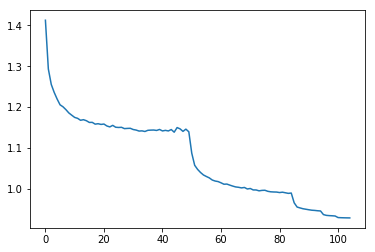

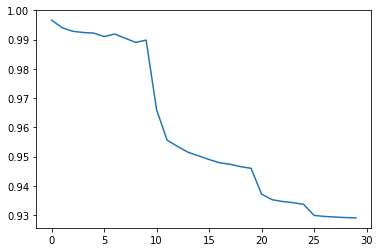

In [428]:
# Model restore
loaded_model, loaded_files_dict = load_model_from_disk(date='20180529-1637')
print('\n## model fully loaded ! \n\n')

print('\n## Plot training history :')
plot_training_session(loaded_files_dict['trainset_infos'], loaded_files_dict['history'])

print('\n## Generate sample name :')
generate_name(
    model=loaded_model,
    trainset_infos=loaded_files_dict['trainset_infos'],
    trainset_utils=loaded_files_dict['trainset_utils'],
    name_max_length=25,
    verbose=True
)